Generating synthetic rockfall dataset...
Dataset shape: (11033, 32)
   num_feature_1  num_feature_2  num_feature_3  num_feature_4  num_feature_5  \
0       0.496714      -0.138264       0.647689       1.523030      -0.234153   
1      -1.150994       0.375698      -0.600639      -0.291694      -0.601707   
2      -0.676922       0.611676       1.031000       0.931280      -0.839218   
3       0.091761      -1.987569      -0.219672       0.357113       1.477894   
4      -0.161286       0.404051       1.886186       0.174578       0.257550   

   num_feature_6  num_feature_7  num_feature_8  num_feature_9  num_feature_10  \
0      -0.234137       1.579213       0.767435      -0.469474        0.542560   
1       1.852278      -0.013497      -1.057711       0.822545       -1.220844   
2      -0.309212       0.331263       0.975545      -0.479174       -0.185659   
3      -0.518270      -0.808494      -0.501757       0.915402        0.328751   
4      -0.074446      -1.918771      -0.026514

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:43:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best CV accuracy for XGBoost: 0.6823

Evaluating RandomForest on test data:
Test Accuracy: 0.6756

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1075
           1       0.67      0.73      0.70      1132

    accuracy                           0.68      2207
   macro avg       0.68      0.67      0.67      2207
weighted avg       0.68      0.68      0.67      2207



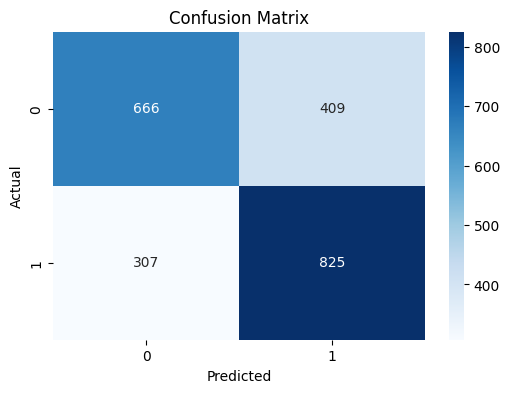


Evaluating SVM on test data:
Test Accuracy: 0.6647

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      1075
           1       0.67      0.68      0.68      1132

    accuracy                           0.66      2207
   macro avg       0.66      0.66      0.66      2207
weighted avg       0.66      0.66      0.66      2207



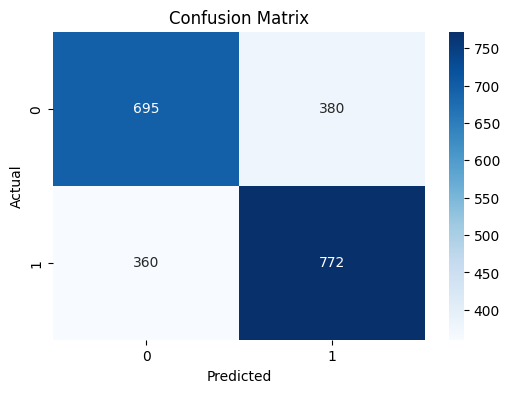


Evaluating XGBoost on test data:
Test Accuracy: 0.6769

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      1075
           1       0.68      0.69      0.69      1132

    accuracy                           0.68      2207
   macro avg       0.68      0.68      0.68      2207
weighted avg       0.68      0.68      0.68      2207



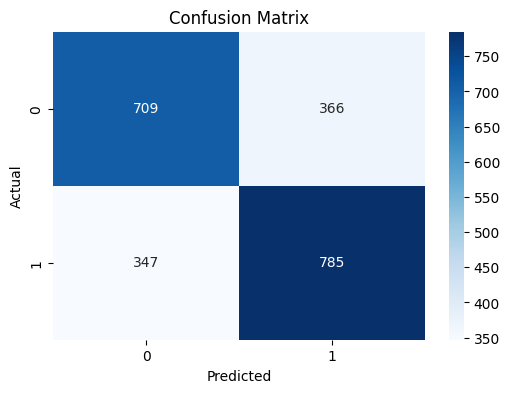


Saving best model: XGBoost


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def generate_synthetic_rockfall_data(n_samples=11033, n_features=31, random_state=42):
    np.random.seed(random_state)

    # Generate numerical features
    X_numeric = np.random.randn(n_samples, n_features - 5)

    # Generate some categorical features (5 categorical columns)
    cat_features = []
    for _ in range(5):
        cat_features.append(np.random.choice(['A', 'B', 'C', 'D'], size=n_samples))
    X_categorical = np.array(cat_features).T

    # Combine into DataFrame
    num_cols = [f"num_feature_{i+1}" for i in range(X_numeric.shape[1])]
    cat_cols = [f"cat_feature_{i+1}" for i in range(X_categorical.shape[1])]

    df_num = pd.DataFrame(X_numeric, columns=num_cols)
    df_cat = pd.DataFrame(X_categorical, columns=cat_cols)

    data = pd.concat([df_num, df_cat], axis=1)

    # Generate binary target with some dependence on features
    # For synthetic purpose, sum of first 3 numerical features + noise determines probability
    prob = (df_num['num_feature_1'] + df_num['num_feature_2'] * 0.5 - df_num['num_feature_3'] * 0.2)
    prob = 1 / (1 + np.exp(-prob))  # Sigmoid for probability
    y = (np.random.rand(n_samples) < prob).astype(int)

    data['rockfall_occurred'] = y
    return data

def preprocess_and_feature_engineer(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)
        ])

    return X, y, preprocessor

def train_and_tune_models(preprocessor, X_train, y_train):
    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    param_grids = {
        'RandomForest': {
            'classifier__n_estimators': [100],
            'classifier__max_depth': [None, 10],
            'classifier__min_samples_split': [2, 5]
        },
        'SVM': {
            'classifier__C': [1],
            'classifier__kernel': ['rbf']
        },
        'XGBoost': {
            'classifier__n_estimators': [100],
            'classifier__max_depth': [3],
            'classifier__learning_rate': [0.1]
        }
    }

    best_estimators = {}
    cv_results = {}

    for name, model in models.items():
        print(f"\nTraining and tuning {name}...")
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        grid_search = GridSearchCV(
            pipe, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        print(f"Best params for {name}: {grid_search.best_params_}")
        print(f"Best CV accuracy for {name}: {grid_search.best_score_:.4f}")

        best_estimators[name] = grid_search.best_estimator_
        cv_results[name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

    return best_estimators, cv_results

def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def main():
    print("Generating synthetic rockfall dataset...")
    data = generate_synthetic_rockfall_data()
    print(f"Dataset shape: {data.shape}")
    print(data.head())

    target_column = "rockfall_occurred"

    X, y, preprocessor = preprocess_and_feature_engineer(data, target_column)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    best_estimators, cv_results = train_and_tune_models(preprocessor, X_train, y_train)

    for name, model in best_estimators.items():
        print(f"\nEvaluating {name} on test data:")
        evaluate_model(model, X_test, y_test)

    best_model_name = max(cv_results, key=lambda k: cv_results[k]['best_score'])
    best_model = best_estimators[best_model_name]
    print(f"\nSaving best model: {best_model_name}")
    joblib.dump(best_model, f"best_rockfall_model_{best_model_name}.joblib")

if __name__ == "__main__":
    main()

In [3]:
def evaluate_model(clf, X_test, y_test, save_predictions=False, output_file="predictions.csv"):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Also get predicted probabilities if classifier supports it
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
    else:
        y_proba = None

    # Print some predictions
    print("Sample predictions (label, probability if available):")
    for i in range(min(10, len(y_pred))):
        if y_proba is not None:
            print(f"Predicted: {y_pred[i]}, Probability: {y_proba[i]:.4f}, Actual: {y_test.iloc[i]}")
        else:
            print(f"Predicted: {y_pred[i]}, Actual: {y_test.iloc[i]}")

    # Optionally save predictions and probabilities to CSV
    if save_predictions:
        pred_df = pd.DataFrame({
            "Actual": y_test,
            "Predicted": y_pred
        })
        if y_proba is not None:
            pred_df["Probability"] = y_proba
        pred_df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")

In [6]:
import joblib
import pandas as pd

def load_model(model_path="best_rockfall_model_XGBoost.joblib"):
    model = joblib.load(model_path)
    return model

def predict_rockfall(model, input_dict):
    """
    input_dict: dict with keys as feature names and values as feature values
    Returns prediction and probability if available.
    """
    # Convert input dict to DataFrame with one row
    input_df = pd.DataFrame([input_dict])

    # Predict class
    pred = model.predict(input_df)[0]

    # Predict probability if available
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(input_df)[0][1]  # Probability of positive class
    else:
        proba = None

    return pred, proba

def main():
    model = load_model()

    # Example: prompt user input for each feature
    # Replace these feature names with your dataset's feature names
    feature_names = model.named_steps['preprocessor'].transformers_[0][2] + \
                    model.named_steps['preprocessor'].transformers_[1][2]

    print("Please input values for the following features:")

    user_input = {}
    for feature in feature_names:
        val = input(f"{feature}: ")
        # Basic numeric conversion attempt
        try:
            val = float(val)
        except:
            pass
        user_input[feature] = val

    pred, proba = predict_rockfall(model, user_input)

    print(f"\nPredicted rockfall occurrence: {pred}")
    if proba is not None:
        print(f"Prediction probability of rockfall: {proba:.4f}")

if __name__ == "__main__":
    main()

Please input values for the following features:
num_feature_1: 6
num_feature_2: 8
num_feature_3: 4
num_feature_4: 8
num_feature_5: 8
num_feature_6: 4
num_feature_7: 0
num_feature_8: 3
num_feature_9: 3
num_feature_10: 0
num_feature_11: 3
num_feature_12: 2
num_feature_13: 3
num_feature_14: 4
num_feature_15: 6
num_feature_16: 7
num_feature_17: 2
num_feature_18: 7
num_feature_19: 1
num_feature_20: 6
num_feature_21: 8
num_feature_22: 8
num_feature_23: 2
num_feature_24: 5
num_feature_25: 3
num_feature_26: 7
cat_feature_1: 9
cat_feature_2: 6
cat_feature_3: 4
cat_feature_4: 3
cat_feature_5: 2

Predicted rockfall occurrence: 1
Prediction probability of rockfall: 0.8659
